In [1]:
import numpy as np         
import pandas as pd
import edward as ed
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as colors


%matplotlib inline

/Users/mortonjt/miniconda3/envs/edward/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/mortonjt/miniconda3/envs/edward/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Simulation

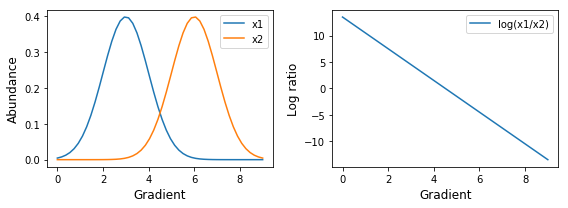

In [2]:
from bayesian_regression.util.sim import chain_interactions

g = np.linspace(0, 9)
x = chain_interactions(g, [3, 6], [1, 1])

# Plot the distributions and log-ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(g, x[:, 0], label='x1') 
ax1.plot(g, x[:, 1], label='x2')
ax2.plot(g, np.log(x[:, 0] / x[:, 1]), label='log(x1/x2)')
ax1.legend()
ax2.legend()
ax1.set_xlabel('Gradient', fontsize=12)
ax1.set_ylabel('Abundance', fontsize=12)
ax2.set_xlabel('Gradient', fontsize=12)
ax2.set_ylabel('Log ratio', fontsize=12)
plt.tight_layout()

Now let's generate the simulated data.

Text(0.5,1,'Simulation')

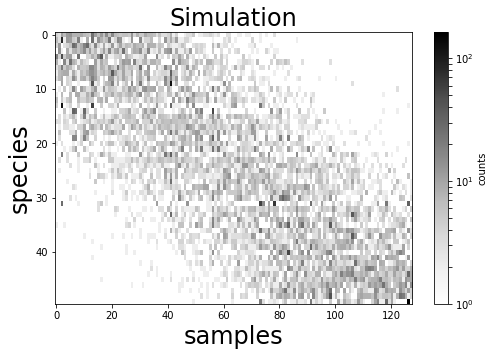

In [3]:
from bayesian_regression.util.generators import band_table
from skbio.stats.composition import _gram_schmidt_basis
from scipy.sparse import coo_matrix

num_samples = 50
num_features = 128

# Build basis for the ilr transform. 
basis = coo_matrix(_gram_schmidt_basis(num_features), dtype=np.float32).T

table, metadata, sim_beta, sim_theta = band_table(
    num_samples, num_features,
    low=2, high=10, sigma=2, alpha=6, seed=0)

# Plot the heatmap of the counts
fig = plt.figure(figsize=(8, 5))
plt.imshow(table.matrix_data.todense().T, aspect='auto', cmap='Greys', norm=colors.LogNorm())
plt.colorbar(label='counts')
plt.ylabel('species', fontsize=24)
plt.xlabel('samples', fontsize=24)
plt.title('Simulation', fontsize=24) 

# Model

In [4]:
from bayesian_regression.util.balances import sparse_balance_basis

# Priors
theta_mean = 0
theta_scale = 1
beta_mean = 0
beta_scale = 1

# Mini batch size
batch_size = 500  

In [5]:
from bayesian_regression.util.model import sparse_matmul
from bayesian_regression.util.balances import ilr_to_clr
from edward.models import Normal, Poisson

N, D = num_samples, num_features
p = metadata.shape[1]   # number of covariates

# dummy variables for mini-batch size                                                            
batch_idx = tf.placeholder(tf.int32, shape=[batch_size], 
                           name='batch_idx')

# dummy variables for mini-batch size
batch_row = tf.placeholder(tf.int32, shape=[batch_size], name='batch_i')
batch_col = tf.placeholder(tf.int32, shape=[batch_size], name='batch_j')

# sample bias                                                                                    
theta = Normal(loc=tf.ones([N, 1]),
               scale=tf.ones([N, 1]),
               name='theta')

# dummy variable for gradient                                                                    
G = tf.placeholder(tf.float32, [N, p], name='G')
# add bias terms for samples
Gprime = tf.concat([tf.ones([N, 1]), G], axis=1)
Gprime = tf.concat([theta, Gprime], axis=1)

# Convert basis to SparseTensor
psi = tf.SparseTensor(
    indices=np.mat([basis.row, basis.col]).transpose(),
    values=basis.data,
    dense_shape=basis.shape)

# Specify regression coefficents
B = Normal(loc=tf.zeros([p+1, D-1]) + beta_mean,
           scale=tf.ones([p+1, D-1]) * beta_scale, 
           name='B')

# clr transform coefficients first                                                               
Bprime = ilr_to_clr(B, psi)
# add bias terms for features
Bprime = tf.concat([tf.ones([1, D]), Bprime], axis=0)
# retrieve entries selected by index
eta = sparse_matmul(
    Gprime, Bprime, 
    row_index=batch_row, col_index=batch_col
)
# obtain counts                                          
Y = Poisson( rate=tf.exp(eta), name='Y' ) 

# Inference

In [6]:
from edward.models import PointMass

# Learning parameters
learning_rate = 1e-1
beta1 = 0.9
beta2 = 0.99
iterations = 5000

# initialize the summaries
summary_dir = 'summary-dir'

In [7]:
# These are the posterior distributions.
# Since we are doing MAP estimation, the posterior distribution is represented as a point estimate
qB = PointMass(
    params=tf.Variable(tf.random_normal([p+1, D-1])) ,
    name='qB')

qtheta = PointMass(
    params=tf.Variable(tf.random_normal([N, 1])),
    name='qtheta')

# a placeholder for the microbial counts
# since we will be manually feeding it into the inference via minibatch SGD
Y_ph = tf.placeholder(tf.float32, shape=[batch_size], name='Y_placeholder')

inference = ed.MAP(
    {B: qB,
     theta: qtheta
    },
    data={G: metadata.values, Y: Y_ph}
)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                   beta1=beta1,    
                                   beta2=beta2)
# adds checks for nans
tf.add_check_numerics_ops()

sess = ed.get_session()
saver = tf.train.Saver()
inference.initialize(n_iter=iterations,
                     optimizer=optimizer,
                     n_print=100,
                     log_vars=[
                         qB,
                         qtheta,
                     ],
                     logdir=summary_dir)
tf.global_variables_initializer().run()

In [8]:
losses = np.array([0.] * inference.n_iter)
errors = np.array([0.] * inference.n_iter)

data = table.matrix_data.tocoo().T
md = np.hstack((np.ones((N, 1)), metadata.values))

y_row, y_col, y_data = data.row, data.col, data.data

In [9]:
from bayesian_regression.util.inference import get_batch


for i in range(inference.n_iter):
    # get batches
    idx_row, idx_col, idx_data = get_batch(M=batch_size, Y=data)

    info_dict = inference.update(
        feed_dict={batch_row: idx_row, batch_col: idx_col, Y_ph: idx_data})
    inference.print_progress(info_dict)
    losses[i] = info_dict['loss']

    if not np.any(np.isnan(sess.run(qB.mean()))):
        b_ = sess.run(qB.mean())
        theta_ = sess.run(qtheta.mean())
        log_u = (md @ b_) @ basis.T + theta_
        err = np.mean((np.exp(log_u[y_row, y_col]) - y_data).ravel() ** 2)
        errors[i] = err

5000/5000 [100%] ██████████████████████████████ Elapsed: 48s | Loss: 1601.720


Store all values as Tensorboard summaries

In [10]:
tf.summary.tensor_summary('qB', qB)
tf.summary.tensor_summary('theta', qtheta)
tf.summary.scalar('beta_mean', beta_mean)
tf.summary.scalar('beta_scale', beta_scale)
tf.summary.scalar('theta_mean', theta_mean)
tf.summary.scalar('theta_scale', theta_scale)
tf.summary.scalar('iteration', iterations)
tf.summary.scalar('learning_rate', learning_rate)
tf.summary.scalar('batch_size', batch_size)
tf.summary.scalar('beta1', beta1)
tf.summary.scalar('beta2', beta2)
tf.summary.scalar('MSE', errors)

<tf.Tensor 'MSE:0' shape=() dtype=string>

Text(0.5,1,'Mean Squared Error')

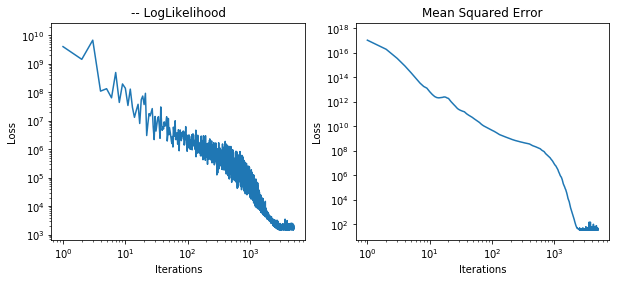

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(losses)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Iterations')
ax[0].set_title('-- LogLikelihood')

ax[1].plot(errors)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Iterations')
ax[1].set_title('Mean Squared Error')

Text(0.5,1,'Simulation')

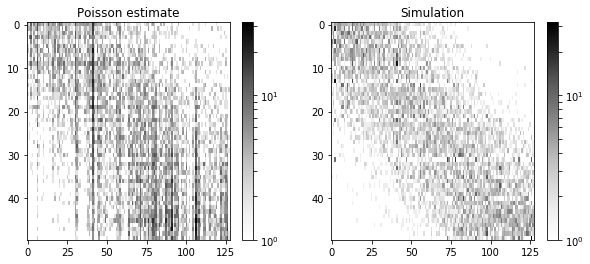

In [12]:
import matplotlib.colors as colors
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

b_ = sess.run(qB.mean()) 
#alpha_ = sess.run(qalpha.mean()) 
theta_ = sess.run(qtheta.mean())
log_u = (md @ b_) @ basis.T + theta_
etable = np.zeros((N, D))
for i in range(etable.shape[0]): 
    etable[i] = np.random.poisson(np.exp(log_u[i]))
img1 = ax[0].imshow(etable, aspect='auto', cmap='Greys', norm=colors.LogNorm())
fig.colorbar(img1, ax=ax[0])
ax[0].set_title('Poisson estimate')

img2 = ax[1].imshow(table.matrix_data.todense().T, aspect='auto', cmap='Greys', norm=colors.LogNorm())
fig.colorbar(img1, ax=ax[1])
ax[1].set_title('Simulation')